<a href="https://colab.research.google.com/github/gusti011/DSIII/blob/main/DSIII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset**: Este dataset agrupa tweets relacionados con el cambio climático recolectados entre el 27 de abril de 2015 y el 21 de febrero de 2018. En total, se anotaron 43,943 tweets. Cada tweet fue etiquetado independientemente por 3 revisores. Este dataset solo contiene los tweets en los que los 3 revisores estuvieron de acuerdo (el resto fueron descartados).

**Objetivo**

El objetivo del modelo es clasificar los tweets sobre el cambio climático en una de las tres etiquetas:

2: noticias - noticias factuales sobre el cambio climático.

1: pro - apoyan la creencia de que el cambio climático es causado por la humanidad.

0: neutral

-1: anti - rechazan la creencia de que el cambio climático es causado por la humanidad.

In [27]:

!pip install spacy==3.5.3
!python -m spacy download en_core_web_sm

import spacy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

2024-12-19 04:36:09.541567: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 04:36:09.580838: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 04:36:09.592574: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 04:36:11.301297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 63.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# **Lectura de datos**

In [38]:
#Previamente cargamos  dataset en github para luego leerlo desde el notebbok
url = 'https://raw.githubusercontent.com/gusti011/DSIII/main/archive%20(1)/twitter_sentiment_data.csv'
df = pd.read_csv(url)

df.head()

,sentiment,message,tweetid
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153


In [29]:
#Observamos estructura de dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  43943 non-null  int64 
 1   message    43943 non-null  object
 2   tweetid    43943 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.0+ MB


# **Análisis de Columna Sentimiento**

In [30]:
# Analizamos la columna de sentimientos para obaservar su distribución
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts

,count
sentiment,
1,22962
2,9276
0,7715
-1,3990


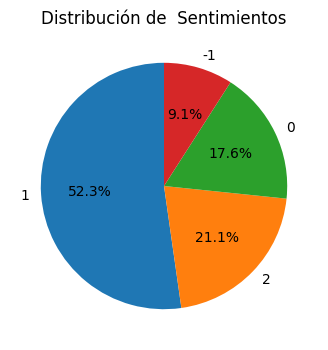

In [31]:
#Graficamos la columna sentiment

import matplotlib.pyplot as plt

# contamos valores de sentimientos
sentiment_counts = df['sentiment'].value_counts()

# Creamos un pie chart
plt.figure(figsize=(4, 4))  # Adjust figure size if needed
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribución de  Sentimientos')
plt.show()

La diferencia significativa en el número de tweets para cada clase de sentimiento indica que el dataset está desbalanceado. Esto podría afectar el rendimiento del modelo

# **Preprocesamiento**

In [39]:
#Creamos la columna Word_count para saber el número de palabras por tweet
df['word_count'] = df['message'].apply(lambda x: len(str(x).split()))

df.head()

,sentiment,message,tweetid,word_count
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,24
1,1,RT @NatGeoChannel: Watch #BeforeTheFlood right...,793124211518832641,17
2,1,Fabulous! Leonardo #DiCaprio's film on #climat...,793124402388832256,14
3,1,RT @Mick_Fanning: Just watched this amazing do...,793124635873275904,17
4,2,"RT @cnalive: Pranita Biswasi, a Lutheran from ...",793125156185137153,21


In [33]:
# Calculamos el promedio de palabras por cada categoria de sentimiento
average_word_counts = df.groupby('sentiment')['word_count'].mean()

average_word_counts

,word_count
sentiment,
-1,18.135088
0,16.259106
1,18.498693
2,15.316731


**Se observa que el sentimento no influye en la extensión de texto**

## **Nube de Palabras**

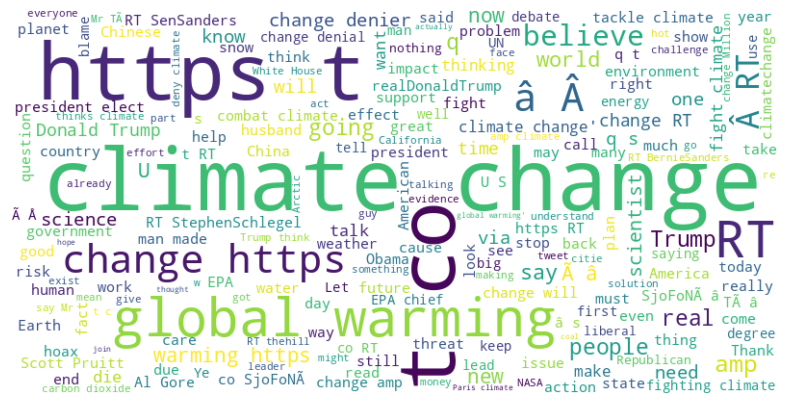

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# unimos todos los tweets en una sola linea
text = " ".join(df['message'].astype(str))

# Creamos la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# graficamos imagen:
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Observamos gran cantidad de palabras vacías**

## **Convertir palabras a minúsculas**

In [41]:
df['message'] = df['message'].str.lower()
df.head()

,sentiment,message,tweetid,word_count
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,24
1,1,rt @natgeochannel: watch #beforetheflood right...,793124211518832641,17
2,1,fabulous! leonardo #dicaprio's film on #climat...,793124402388832256,14
3,1,rt @mick_fanning: just watched this amazing do...,793124635873275904,17
4,2,"rt @cnalive: pranita biswasi, a lutheran from ...",793125156185137153,21


## **Tokenización**

In [42]:
nlp = spacy.load("en_core_web_sm")

def tokenize_message(message):
    doc = nlp(message)
    tokens = [token.text for token in doc]
    return tokens

df['tokens'] = df['message'].apply(tokenize_message)
df.head()

,sentiment,message,tweetid,word_count,tokens
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,24,"[@tiniebeany, climate, change, is, an, interes..."
1,1,rt @natgeochannel: watch #beforetheflood right...,793124211518832641,17,"[rt, @natgeochannel, :, watch, #, beforetheflo..."
2,1,fabulous! leonardo #dicaprio's film on #climat...,793124402388832256,14,"[fabulous, !, leonardo, #, dicaprio, 's, film,..."
3,1,rt @mick_fanning: just watched this amazing do...,793124635873275904,17,"[rt, @mick_fanning, :, just, watched, this, am..."
4,2,"rt @cnalive: pranita biswasi, a lutheran from ...",793125156185137153,21,"[rt, @cnalive, :, pranita, biswasi, ,, a, luth..."


## **Remover caractéres especiales**

In [44]:
import re

def remove_special_characters(tokens):
    # Eliminar caracteres especiales usando expresiones regulares
    # Join the tokens into a single string before applying re.sub
    text = " ".join(tokens)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Split the string back into tokens after removing special characters
    return text.split()

df['tokens'] = df['tokens'].apply(remove_special_characters)
df.head()

,sentiment,message,tweetid,word_count,tokens
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,24,"[tiniebeany, climate, change, is, an, interest..."
1,1,rt @natgeochannel: watch #beforetheflood right...,793124211518832641,17,"[rt, natgeochannel, watch, beforetheflood, rig..."
2,1,fabulous! leonardo #dicaprio's film on #climat...,793124402388832256,14,"[fabulous, leonardo, dicaprio, s, film, on, cl..."
3,1,rt @mick_fanning: just watched this amazing do...,793124635873275904,17,"[rt, mickfanning, just, watched, this, amazing..."
4,2,"rt @cnalive: pranita biswasi, a lutheran from ...",793125156185137153,21,"[rt, cnalive, pranita, biswasi, a, lutheran, f..."


In [47]:
# contar tokens para ver resultado

df['token_count'] = df['tokens'].apply(len)
df.head()

,sentiment,message,tweetid,word_count,tokens,token_count
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,24,"[tiniebeany, climate, change, is, an, interest...",24
1,1,rt @natgeochannel: watch #beforetheflood right...,793124211518832641,17,"[rt, natgeochannel, watch, beforetheflood, rig...",17
2,1,fabulous! leonardo #dicaprio's film on #climat...,793124402388832256,14,"[fabulous, leonardo, dicaprio, s, film, on, cl...",15
3,1,rt @mick_fanning: just watched this amazing do...,793124635873275904,17,"[rt, mickfanning, just, watched, this, amazing...",17
4,2,"rt @cnalive: pranita biswasi, a lutheran from ...",793125156185137153,21,"[rt, cnalive, pranita, biswasi, a, lutheran, f...",21


## **Remover stopwords**

In [48]:
from spacy.lang.en.stop_words import STOP_WORDS

def remove_stopwords(tokens):
    filtered_tokens = [token for token in tokens if token not in STOP_WORDS]
    return filtered_tokens

df['tokens'] = df['tokens'].apply(remove_stopwords)
df.head()

,sentiment,message,tweetid,word_count,tokens,token_count
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,24,"[tiniebeany, climate, change, interesting, hus...",24
1,1,rt @natgeochannel: watch #beforetheflood right...,793124211518832641,17,"[rt, natgeochannel, watch, beforetheflood, rig...",17
2,1,fabulous! leonardo #dicaprio's film on #climat...,793124402388832256,14,"[fabulous, leonardo, dicaprio, s, film, climat...",15
3,1,rt @mick_fanning: just watched this amazing do...,793124635873275904,17,"[rt, mickfanning, watched, amazing, documentar...",17
4,2,"rt @cnalive: pranita biswasi, a lutheran from ...",793125156185137153,21,"[rt, cnalive, pranita, biswasi, lutheran, odis...",21


In [49]:
# contar tokens para ver resultado

df['token_count'] = df['tokens'].apply(len)
df.head()

,sentiment,message,tweetid,word_count,tokens,token_count
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,24,"[tiniebeany, climate, change, interesting, hus...",14
1,1,rt @natgeochannel: watch #beforetheflood right...,793124211518832641,17,"[rt, natgeochannel, watch, beforetheflood, rig...",13
2,1,fabulous! leonardo #dicaprio's film on #climat...,793124402388832256,14,"[fabulous, leonardo, dicaprio, s, film, climat...",11
3,1,rt @mick_fanning: just watched this amazing do...,793124635873275904,17,"[rt, mickfanning, watched, amazing, documentar...",10
4,2,"rt @cnalive: pranita biswasi, a lutheran from ...",793125156185137153,21,"[rt, cnalive, pranita, biswasi, lutheran, odis...",15


In [51]:
#ver lista de palabras conteo

from collections import Counter

def word_count(df):
    # Join all preprocessed tokens into a single list
    all_tokens = [token for tokens in df['tokens'] for token in tokens]

    # Count word frequencies
    word_counts = Counter(all_tokens)

    # Convert to DataFrame for better visualization
    word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])
    word_counts_df = word_counts_df.sort_values('count', ascending=False)

    return word_counts_df

# Example usage (assuming your DataFrame is named 'df')
word_counts_df = word_count(df)
word_counts_df. head(40)

,count
climate,35166
change,34169
rt,25320
global,10899
warming,10146
s,8183
trump,4999
nt,4559
believe,2360
amp,2248


In [53]:
# agregar stopwords: rt,  , s, nt, https, m, t,

# agregar stopwords
new_stop_words = ["rt", ",", "s", "nt", "https", "m", "t"]
STOP_WORDS.update(new_stop_words)

# Function to remove stop words (updated to use the new STOP_WORDS set)
def remove_stopwords(tokens):
    filtered_tokens = [token for token in tokens if token not in STOP_WORDS]
    return filtered_tokens

df['tokens'] = df['tokens'].apply(remove_stopwords)
df.head()

# contar tokens para ver resultado
df['token_count'] = df['tokens'].apply(len)
df.head()

#ver lista de palabras conteo
def word_count(df):
    # Join all preprocessed tokens into a single list
    all_tokens = [token for tokens in df['tokens'] for token in tokens]

    # Count word frequencies
    word_counts = Counter(all_tokens)

    # Convert to DataFrame for better visualization
    word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['count'])
    word_counts_df = word_counts_df.sort_values('count', ascending=False)

    return word_counts_df

# Example usage (assuming your DataFrame is named 'df')
word_counts_df = word_count(df)
word_counts_df.head()

,count
climate,35166
change,34169
global,10899
warming,10146
trump,4999


## **Lematización**

In [55]:
def lemmatize_tokens(tokens):
    lemmatized_tokens = [token.lemma_ for token in nlp(" ".join(tokens))]
    return lemmatized_tokens

df['tokens'] = df['tokens'].apply(lemmatize_tokens)
df.head()

,sentiment,message,tweetid,word_count,tokens,token_count
0,-1,@tiniebeany climate change is an interesting h...,792927353886371840,24,"[tiniebeany, climate, change, interesting, hus...",14
1,1,rt @natgeochannel: watch #beforetheflood right...,793124211518832641,17,"[natgeochannel, watch, beforetheflood, right, ...",12
2,1,fabulous! leonardo #dicaprio's film on #climat...,793124402388832256,14,"[fabulous, leonardo, dicaprio, film, climate, ...",10
3,1,rt @mick_fanning: just watched this amazing do...,793124635873275904,17,"[mickfanne, watch, amazing, documentary, leona...",9
4,2,"rt @cnalive: pranita biswasi, a lutheran from ...",793125156185137153,21,"[cnalive, pranita, biswasi, lutheran, odisha, ...",14


## **Creación de Modelo**

In [56]:
# prompt: Bag of words CountVectorizer ngrams

from sklearn.feature_extraction.text import CountVectorizer

# Join tokens back into strings for CountVectorizer
df['processed_text'] = df['tokens'].apply(lambda tokens: ' '.join(tokens))

# Initialize CountVectorizer with ngram_range
vectorizer = CountVectorizer(ngram_range=(2, 3))

# Fit and transform the text data
X = vectorizer.fit_transform(df['processed_text'])

# Get feature names (ngrams)
feature_names = vectorizer.get_feature_names_out()

# Print some of the ngrams
print(feature_names[:50]) # Adjust the number as needed

# Now X contains the bag-of-words representation with ngrams
# You can use X for further processing or model training

['000 usd' '000 usd minimum' '0000058 defendscie' '0001jatt human'
 '0001jatt human responsible' '0005c warm' '0005c warm disaster'
 '000we need' '000we need hit' '001harpinder semi'
 '001harpinder semi arid' '004 change' '004 change climate'
 '007 httpstcobj0tavesr3' '007 httpstcobj0tavesr3 httpstcoahmfknc6s9'
 '009barca madmasterr' '009barca madmasterr yes' '00kevin7 mannyottawa'
 '00kevin7 mannyottawa ecosensenow' '01 22' '01 22 news' '010 ps4share'
 '010 ps4share httpstcoqbkugnjscc' '010536 http' '012 httpstcoamfpboob4'
 '012 httpstcoamfpboob4 httpstcomccvymlp0v' '01kenyabiologics mitigate'
 '01kenyabiologics mitigate climate' '02 decrease' '02 pm' '02 pm modi'
 '02 trump' '02 trump decision' '020 38' '020 38 29'
 '02cents0 positivelyjoan' '02cents0 positivelyjoan doughravme' '03 24'
 '03 24 earthhour' '0301 2219' '04 drink' '04 drink drive'
 '04 httpstcowiovmugsbj' '04082017 update' '04082017 update research'
 '0463diamond study' '0463diamond study find' '049 kwh' '049 kwh solar'


In [57]:
# prompt: train test split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['sentiment'], test_size=0.2, random_state=42)

In [58]:
# prompt: accuracy

# Assuming you have already trained your model (X_train, X_test, y_train, y_test are defined)

# Initialize and train a Logistic Regression model
model = LogisticRegression(max_iter=1000) # Increased max_iter for convergence
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Generate classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.6748207987256798
              precision    recall  f1-score   support

          -1       0.81      0.30      0.44       784
           0       0.54      0.39      0.45      1582
           1       0.67      0.89      0.77      4514
           2       0.77      0.56      0.65      1909

    accuracy                           0.67      8789
   macro avg       0.70      0.53      0.58      8789
weighted avg       0.68      0.67      0.65      8789

